#SETUP

!Disclaimer - below code (with some modifications) is an exercise from Hand-On-ML exercises. Original you can find under this [link](https://github.com/dataqueenpend/handson-ml2/blob/master/03_classification.ipynb).

In [1]:
import sklearn
import numpy as np
import os

#For stable outputs across the notebook
np.random.seed(42)

#Pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Saving figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tigh_layout=True, fig_extension='png', resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
  print('Saving figure', fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.save_fig(path, format=fig_extension, dpi=resolution)

#MNIST

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

Dataset has 70 000 images. Each image has 784 features. 

---
Each image is 28 x 28 pixels, and each feature represents one pixel's intensity from 0 to 255. 

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

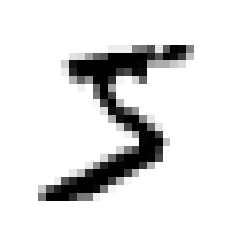

In [9]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [10]:
y[0]

'5'

Picture looks like 5. And label show it is 5. 

---

y is a string, which will be tough for the ML to deal with. Let's imput it to the integer.

In [11]:
y = y.astype(np.uint8)

##Train, test split

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Data is already shuffled, so we don't risk that some fold will be missing some digits. 

> Some ML can perform bad, if they get many similar instances in a row. But shuffling can be not such a good idea, when we're dealing with f.e. time-series data -> stock market prices, weatcher predictions etc. 

##Training Binary Classifier

For simplification of a problem let's try to train the model for predicting either the number is 5 or not. 

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test ==5)

###Stochastic Gradient Descent

+ capable of handling very large datasets efficieny
  > this is because SGD handles training instances indepedently - one at a time - which make it good for online learning as well

In [14]:
#Creating SGD object and training on the whole train set

from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf = SGDClassifier(random_state=42)

In [16]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

In [18]:
#Checking cross-val-score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Classifier guessed right. 

Let's try evalute the model performance. 

##Performance Measures

**Evaluation of the Classifier is trickier than evaluating regressor.**

###Cross Validation

There is part of interesting code for cross validation from handson-ml2 

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


####Cross validation with cross_val_score sklearn

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Taking aa look at some classifier that classifies every image as not-5

In [22]:
from sklearn.base import BaseEstimator

In [23]:
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [24]:
never_5_clf = Never5Classifier()

In [25]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This classifier gueeses 100% 5. But if only 10% of the images are not 5, than the classifier is right in the 90%. 

> That's why accuracy is not the best way to evaluate performance of the classifiers. **Especially with skewed datasets**. 

###Confusion Matrix

> Evaluation by counting the number of times instances of clas A are classified as class B

  * if we know that classifier confused images of 5s with 3s, we go to the 5th row and 3rd column of the confusion matrix



In [26]:
from sklearn.model_selection import cross_val_predict

In [27]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

1st row
* 53892 were correctly classified as non 5 images (negative class) / 687 were wrongly classified as non 5 (false positives)

2nd row
* 1891 were wrongly classified as 5s (false positives), and 3530 were correctly classified as 5s (true positives). 

---

**Perfect classifier would have nonzero values only on its main diagonal**

Like this:



In [30]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

###Precision and Recall

In [31]:
from sklearn.metrics import precision_score, recall_score

In [32]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [33]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [34]:
from sklearn.metrics import f1_score

In [35]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

####Precision/Recall Trade-off

In [36]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
treshold = 0
y_some_digit_pred = (y_scores > treshold)

In [38]:
treshold = 8000
y_some_digit_pred = (y_scores > treshold)
y_some_digit_pred

array([False])

#####How to decide which treshold to use?

With cross_val_predict() function to get the scores of all instances, but with argument method set to 'decision_function'. 

> This way cross_val_predict() will return decision scores instead of predictions. 

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

On this scores we will use precision_recall_curve() to compute precision and recall for all possible tresholds. 

In [40]:
from sklearn.metrics import precision_recall_curve

In [41]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Then we can use Matplotlib to plot precision and recall function of the treshold value. 

In [42]:
def plot_precision_recall_vs_treshold(precisions, recalls, tresholds):
  plt.plot(tresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
  plt.plot(tresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
  plt.legend(loc='center right', fontsize=16)
  plt.xlabel('Treshold', fontsize=16)
  plt.grid('True')
  plt.axis([-50000, 50000, 0,1])

In [43]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

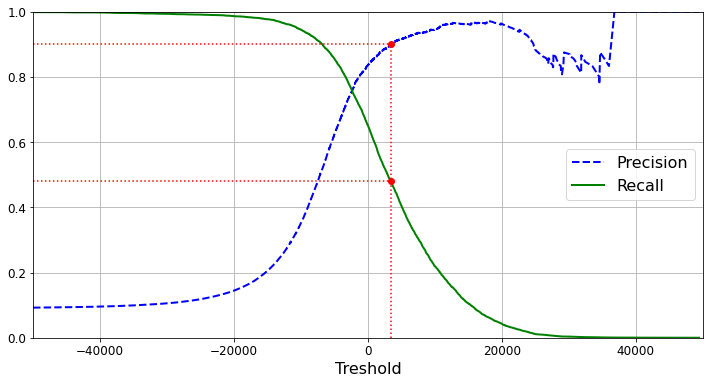

In [44]:
plt.figure(figsize=(12,6))
plot_precision_recall_vs_treshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([threshold_90_precision], [0.9], 'ro')
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')
plt.show()

Another way to select good precision/recall trade-off is to plot precision directly against recall.

In [45]:
def plot_precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, 'b--', linewidth=2)
  plt.xlabel('Recall', fontsize=16)
  plt.ylabel('Precision', fontsize=16)
  plt.axis([0,1,0,1])
  plt.grid(True)

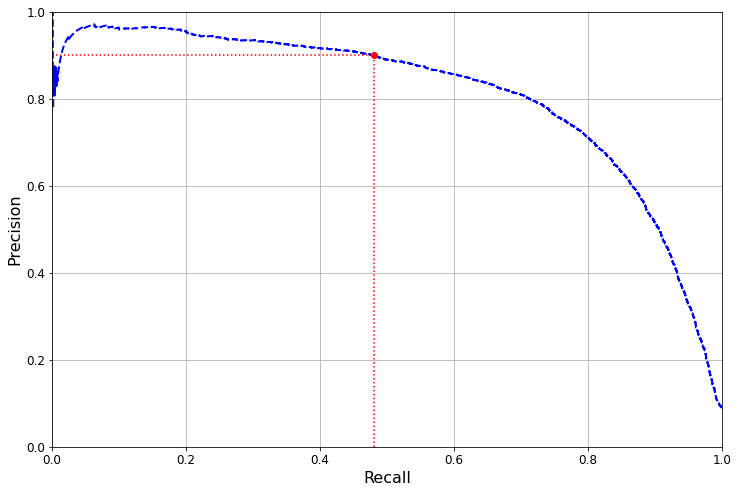

In [46]:
plt.figure(figsize=(12,8))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], 'r:')
plt.plot([0.0, recall_90_precision], [0.9, 0.9], 'r:')
plt.plot([recall_90_precision], [0.9], 'ro')
plt.show()

In [47]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [48]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [49]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [50]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

###ROC Curve

- plots true positive rate, against false positive rate


####How to plot ROC curve?

First use roc_curve() from sklearn to compute TPR  and FPR for various treshold values

In [51]:
from sklearn.metrics import roc_curve

In [52]:
fpr, tpr, tresholds = roc_curve(y_train_5, y_scores)

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') #Dashed diagonal
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate (Fall_Out)', fontsize=16)
  plt.ylabel('True Positive Rate (Recall', fontsize=16)
  plt.grid(True)

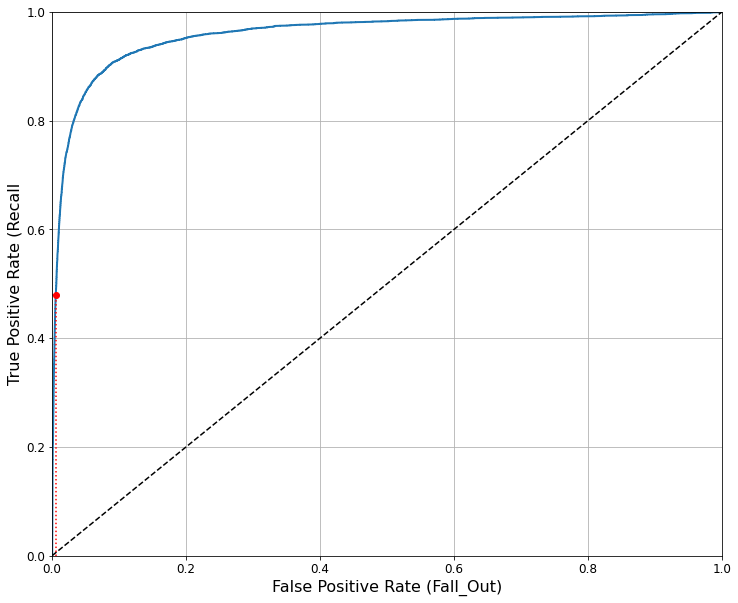

In [54]:
plt.figure(figsize=(12,10))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], 'r:')
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], 'ro')
plt.show()

####AUC

Perfect classifier will have ROC AUC equal to 1. Where a purely random classifier will have ROC AUC equal to 0.5. 

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

When to use P/R and when to use ROC AUC?

* PR is a good measure when the positive class is rare or when we care more about the false positive than the false negative. 

In this example, we could think - by looking on AUC - that our model is really good. But by looking on Precision/Recall curve, we can cleraly see that the model has a lot room for improvement - the curve could be close to the top left corner. 

## Training RandomForestClassifier and comparing results with ROC curve and scores to the SGDClassifier

Getting scores from RMFClas with '''predict_proba()''' function

> RMF does not have a decision_function(), instead it use predict_proba(). In sklearn models have either the first or the second function for getting scores. 

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

roc_curve() function expects labels and scores, but insted of scores class probabilites can be used

In [58]:
y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, tresholds_forest = roc_curve(y_train_5, y_scores_forest)

Plotting ROC curve

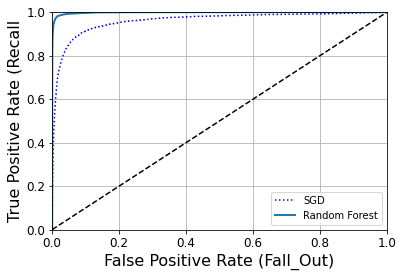

<Figure size 1440x1080 with 0 Axes>

In [59]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.figure(figsize=(20,15))
plt.show()


## Multiclass Classification

... classifies between more than two classes. Some classifier can be used natively to predict multiclass classification (SGD, RMF, naive Bayes) others (Logistic Reg, SVM) are stricly binary classifiers. 

But there are multiple strategies that we can use to perform multiclass classification with multiple binary classifiers. 

** OvR - One versus the rest ** 
> Create 10 classifiers one for each digit to classify the image, get the decision score from each classifier for that image and select class whose classifier has the highest score. 

** OvO - One versus One **
> Create binary classifier for each pair of the digits. Upon classifying an image, the image has to be run through all the created classifiers. We then store the result  which class wins the most duels. 
    * Number of classifiers to train is calculated with N * (N-1)/2, where N is number of classes. For MNIST dataset we'd need to train 45 classifiers. Which is a lot. Which means it is problematic. 
        * OvO is preffered when we are dealing with algorithms, which scales poorly on small data samples. While using SVM it is more advisibale to use OvO to train many classifiers on small training sets, than train few classifiers on large training sets. 
        
 In most cases, though, OvR is the way to go. 
 
 ---
 
 Scikit-Learn detects that we want to use binary classification algo for multiclass classification task, and it pick the OvR or OvO accordinglly. 


In [60]:
from sklearn.svm import SVC

In [61]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #We use all y train, not only y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Scikit_learn SVM trained underthehood 45 binary classifiers by using the OvO strategy, got their decision scores for the image and selected the class that won the most duels. 

---
Let's call decision_function() on the results. 

In [63]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [64]:
np.argmax(some_digit_scores)

5

The highest scores corresponds to class 5.

In [65]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [66]:
svm_clf.classes_[5]

5

classes_ attributes stores the list of classes, ordere by values. It is not always the case that that index of the array will match the values of the class (like in this case).

---

> We can force Scikit-Learn to use either OvO or OvR strategy, by calling the these classes straight form the sklearn.multiclass.
    * Remember that we need to pass a classifier to its constructor. (it doesn't need to to be binary classifier)

In [67]:
from sklearn.multiclass import OneVsRestClassifier

In [69]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [70]:
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

Let's train SGD this time

In [71]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [72]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

SGD classifier directly classified intances into multiple classes. So it doesn't need to have run OvR or OvO classifiers. It results in taking less time to fit the model and predict results. But if SGD was more accurate in it predictions?

From what it looks at the first sight, almost all scores are largely negative, which could indicate confident predictions of the model. We can spott some uncertainity of the model with class 3 and 5 (higher values). 

In [73]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Over 85% on all folds. Of course it can be better. 

Let's scale the data. 

In [74]:
from sklearn.preprocessing import StandardScaler

In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis 
Next step in project pipeline would be to explores data preparation options, trying out multiple models, shortlisting and fine_tuning the best one using GridSearchCV (or Optuna?), and automating the process as much as possible. 

For now, we'll assume that we've found the most promising model and we'll try to find ways to improve it. 

---

First step in this process can be to analyze types of error the model makes. Let's start with making prediction with cross_val_predict() and then comparing it with confusion matrix. 

In [76]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [77]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

It is hard to read for human in a form like this. ** To make it more readable ** we'll use Matplotlib's matshow() function.

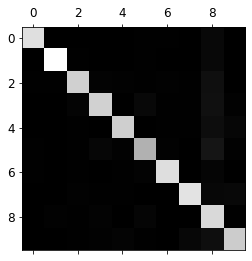

In [78]:
plt.matshow(conf_mx, %%cmdap=plt.cm.gray)
plt.show()

We see that most images are on the main diagonal, which indicates that they were predicted correctly. 5s is slightly darker than other digits. Which could mean couple of things:
* not enough 5s images in the dataset, 
* model is not performing well on 5s as on other digits. 

---

Let's focus the plot on the errors. 